# Building An ARIMA Model

In [363]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import seaborn as sns
import random 

import warnings
warnings.filterwarnings("ignore")

In [364]:
#Reading in the data
df = pd.read_csv('data/bed_bath_table_sales.csv', header = 0)

In [365]:
df.head()

,yw_dt,payment_value
0,2017-01-02,84.59
1,2017-01-09,302.81
2,2017-01-16,1526.00
3,2017-01-23,1382.70
4,2017-01-30,3523.66


In [366]:
#Converting the 'yw_dt' column to a datetime datatype
df['yw_dt'] = pd.to_datetime(df['yw_dt'])

In [367]:
#Setting the 'yw_dt' column as the index for the dataframe
df = df.set_index('yw_dt')

### Data Stationarity

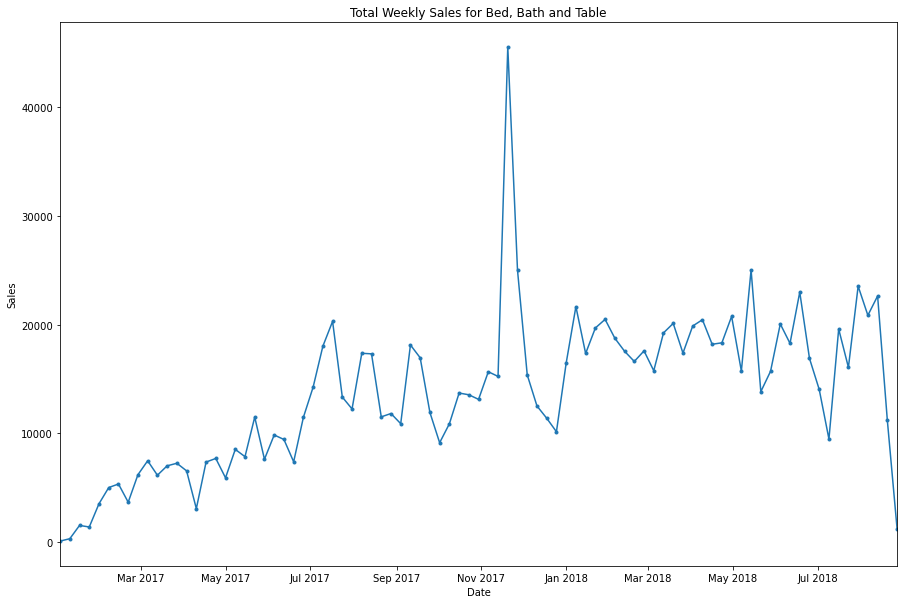

In [368]:
#Plotting the data to see how it changes over time
plt.figure(figsize = (15,10))
ax = plt.gca()
plt.plot(df, marker='.')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Total Weekly Sales for Bed, Bath and Table')
ax.autoscale(enable=True, axis='x', tight=True)
ax.xaxis.set_major_formatter(DateFormatter("%b %Y"))
plt.show();

From the graph above, we can see that our data is not stationary. We seem to have an upward trend in the sales over time. To more clearly see this, we can decompose our data into the 'trend', 'seasionality' and 'residual' components.

In [369]:
#Decomposing the data to determine the trend, seasonal component and residual components
#Because we have less than 2 cycles of data, we have had to limit our freq to less than 52 to obtain results
from statsmodels.api import tsa

decomposition = tsa.seasonal_decompose(df, model='additive', freq = 17)

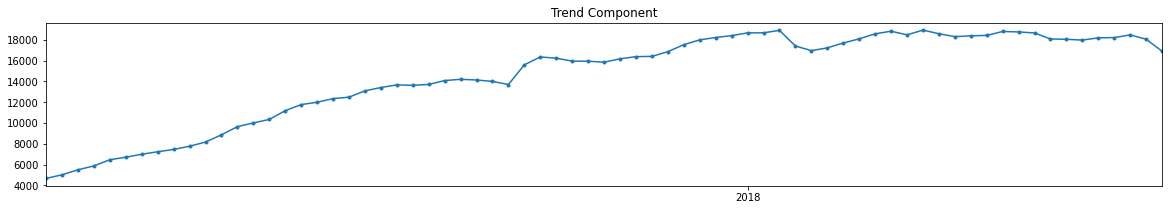

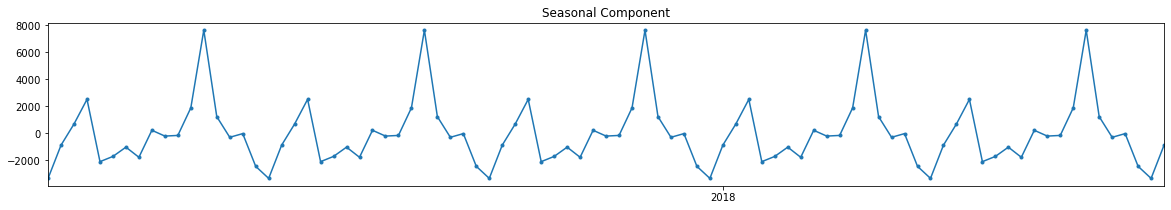

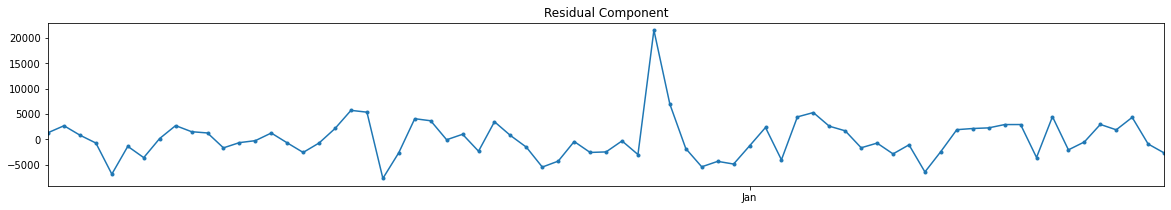

In [370]:
# Graphing the Trend
plt.figure(figsize = (20,3))
plt.plot(decomposition.trend, marker='.')
plt.title('Trend Component')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.autoscale(enable=True, axis='x', tight=True)
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
plt.show();

# Graphing the Seasonal component
plt.figure(figsize = (20,3))
plt.plot(decomposition.seasonal, marker='.')
plt.title('Seasonal Component')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.autoscale(enable=True, axis='x', tight=True)
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
plt.show();

# Graphing the Residuals
plt.figure(figsize = (20,3))
plt.plot(decomposition.resid, marker='.')
plt.title('Residual Component')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.autoscale(enable=True, axis='x', tight=True)
ax.xaxis.set_major_formatter(DateFormatter("%b"))
plt.show();

From the above results, we can see that we do indeed have an upward trend in our sales data, suggesting that we do not have stationary information. Attempting to build a model on this data as is would not yield useful results as the historical transactions would not be able to highlight the upward trend in sales. We can also see from the decomposition of the data that we do have a seasonal component in the data as well. In order to model this data correctly, we need to obtain stationary data where historical information can more accurately model future behavior. 

From the weekly sales graph, we can see that we do have a positive upward trend in sales, although no strong, it is present. Thus, to remove this trend, we can attempt to take a difference between the current sales value and the previous sales value. This would give us the weekly change in sales. We can then re-graph our resulting data to see if we have been able to establish stationarity, which would allow us to move forward with modelling.

In [371]:
# Making data stationary through differencing
df_diff = df.diff().dropna()

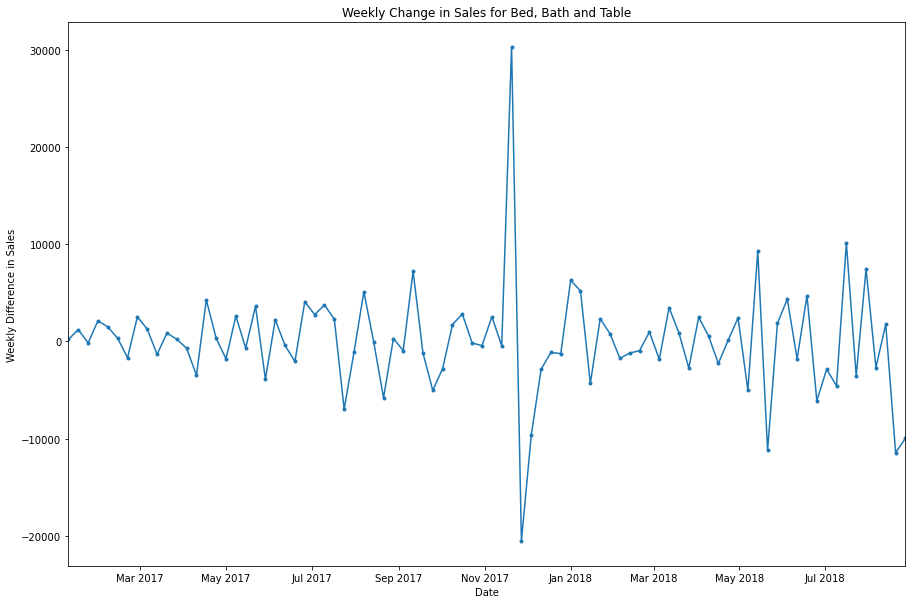

In [372]:
plt.figure(figsize = (15,10))
ax = plt.gca()
plt.plot(df_diff, marker='.')
plt.xlabel('Date')
plt.ylabel('Weekly Difference in Sales')
plt.title('Weekly Change in Sales for Bed, Bath and Table')
ax.autoscale(enable=True, axis='x', tight=True)
ax.xaxis.set_major_formatter(DateFormatter("%b %Y"))
plt.show();

We can see that be taking the difference we were able to effectively make the data stationary with the data being centered at zero. While visually this implies that we can now use this to build our model, we need to fully ensure that our data is indeed stationary. To more robustly, confirm this, we can perform the Augmented Dickey-Fuller test. The following code for the Dickey-Fuller test was obtained from: https://www.kaggle.com/sumi25/understand-arima-and-tune-p-d-q. 

Given that this code provides all the information needed in an organized manner, the code was used to aid in performing the Dickey-Fuller test.

In [373]:
from statsmodels.tsa.stattools import adfuller

#Perform Dickey-Fuller test:
def dickey_fuller(data, cutoff = 0.05):
    
    print('Results of Dickey-Fuller Test:')
    
    dftest = adfuller(data, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

In [374]:
#Checking the results
print(dickey_fuller(df_diff))

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -5.736354e+00
p-value                        6.424903e-07
#Lags Used                     7.000000e+00
Number of Observations Used    7.800000e+01
Critical Value (1%)           -3.517114e+00
Critical Value (5%)           -2.899375e+00
Critical Value (10%)          -2.586955e+00
dtype: float64
None


From the Dickey-Fuller test, we can see that we have an extremely small p-value that is well below the 5% threshold. From our Test Statistic, we can see that we are below the 1% critical value as well, suggesting that the 1st order differencing has yielded a stationary dataset that we can use for modeling.

In [375]:
#splitting the data into train and test
test_size = int(0.3*df_diff.shape[0])

test = df_diff[-test_size:]
train = df_diff[:-test_size]

In [376]:
print(train.shape)
print(test.shape)

(61, 1)
(25, 1)


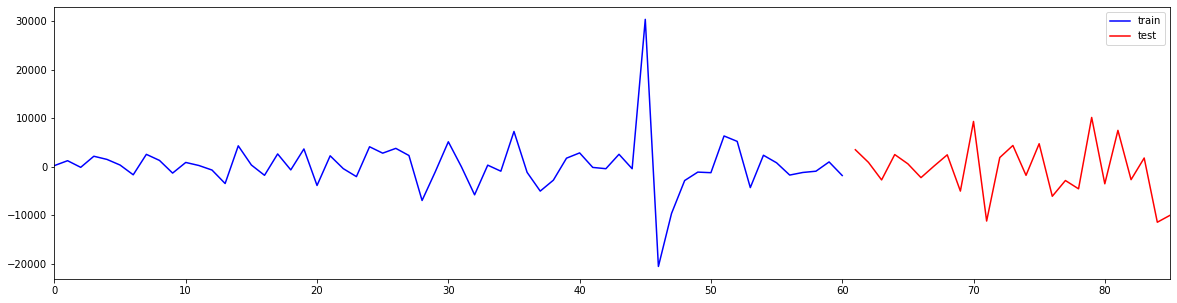

In [377]:
#Plotting the data again, but now with colour coatting to define train and test data
plt.figure(figsize = (20,5))
plt.plot(list(range(0, len(train))), train, c="blue", label="train")
plt.plot(list(range(len(train), len(train)+len(test))),test, c="red", label="test")
plt.xlim([0, 85])
plt.legend()
plt.show();

### Autocorrelation

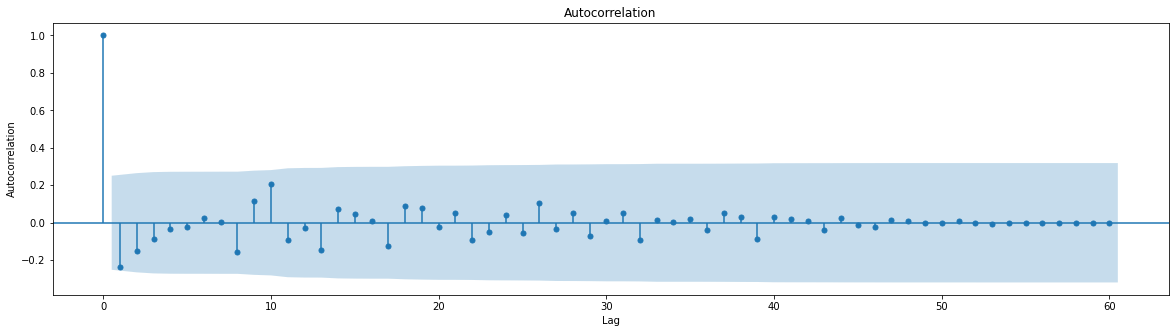

In [378]:
#Looking at autocorrelation of the data
from statsmodels.graphics.tsaplots import plot_acf
fig, ax = plt.subplots(figsize=(20, 5))
plot_acf(train, lags = 60, ax=ax)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show();

Looking at the autocorrelation plot above, we can see that all the autocorrelation values fall within the confidence intervals calculated by the acf function, suggesting that we do not have autocorrelation values that are statistically significant. We can also see that autocorrelation values seem to gradually converge to zero as we increase the number of lags. By ~lag 20, much of the autocorrelation that we see has diminished with most of the remaining values reaching zero. Thus, given this, while we do not have statistically significant autocorrelation values, we can plot the partial autocorrelation with up to lag of 20 and determine if there are significant autoregressive terms.

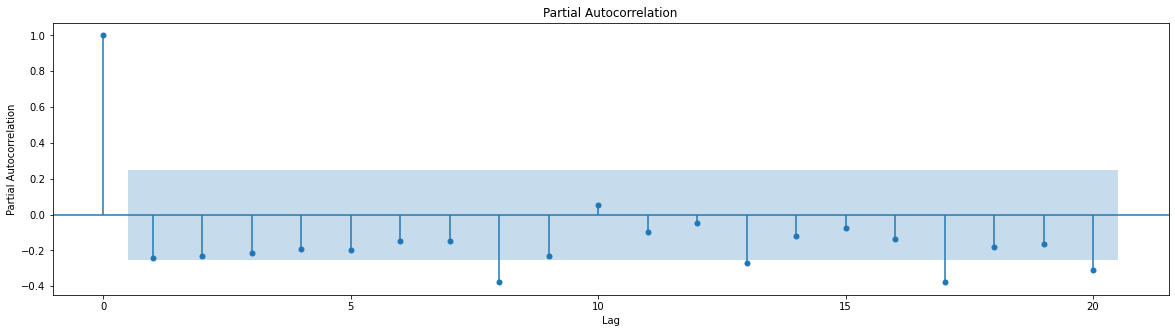

In [379]:
#looking at the partial autocorrlation plot
from statsmodels.graphics.tsaplots import plot_pacf
fig, ax = plt.subplots(figsize=(20, 5))
plot_pacf(train, lags=20, ax=ax)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()

Plotting the partial autocorrelation, we can see that we do indeed have Lag values that fall outside the confidence intervals suggesting statistically significant partial autocorrelation. Since partial autocorrelation gives us the autocorrelation after removing the effect of any correlations resulting from terms at shorter lags, we get a much clearer image of how many days in the past are important when fitting a model. From here, we can see the largest partial autocorrelation to be at at a Lag value of 8 and 17 where we have a partial autocorrelation that falls outside of the confidence intervals. Interesting, we also have lag values of 13, and 20 where we see partial autocorrelation also outside of the confidence intervals, albeit not as large as what we see for lags 8 and 17. Given this, we can test an AR model with these lag values to see how the AR model performs against the true sales values.

In [380]:
len(train)

61

In [381]:
len(train)+15

76

### Autoregressive Model

Lag: 8
Coefficients: const               1180.555966
L1.payment_value      -0.497413
L2.payment_value      -0.516041
L3.payment_value      -0.516500
L4.payment_value      -0.477842
L5.payment_value      -0.434683
L6.payment_value      -0.344007
L7.payment_value      -0.278902
L8.payment_value      -0.332398
dtype: float64


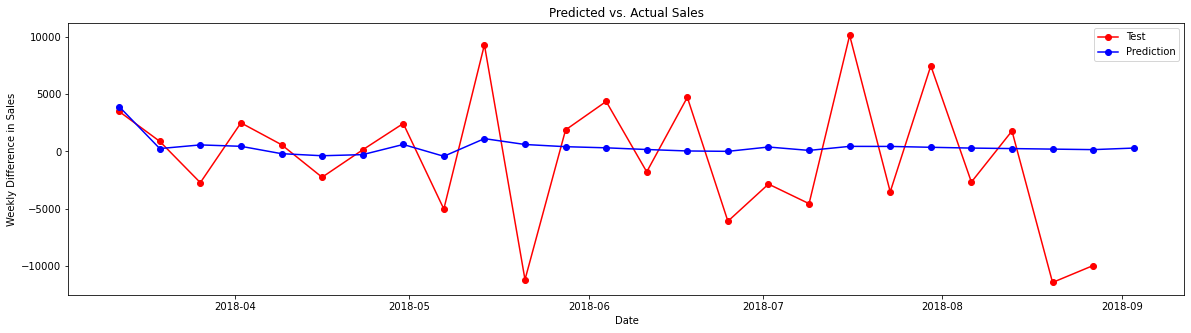

Lag: 13
Coefficients: const                1536.161785
L1.payment_value       -0.549426
L2.payment_value       -0.559022
L3.payment_value       -0.575302
L4.payment_value       -0.587785
L5.payment_value       -0.591347
L6.payment_value       -0.500791
L7.payment_value       -0.447605
L8.payment_value       -0.513357
L9.payment_value       -0.273233
L10.payment_value      -0.064872
L11.payment_value      -0.161938
L12.payment_value      -0.112323
L13.payment_value      -0.181572
dtype: float64


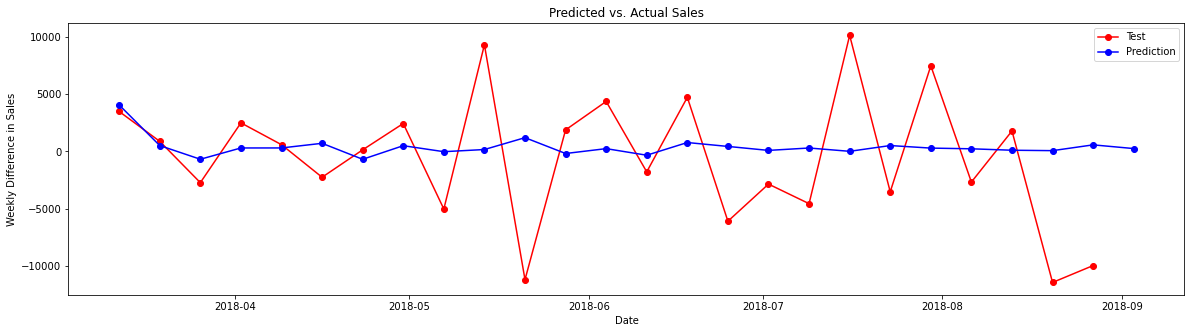

Lag: 17
Coefficients: const                5364.083583
L1.payment_value       -0.693873
L2.payment_value       -0.780611
L3.payment_value       -0.898117
L4.payment_value       -1.022080
L5.payment_value       -0.958275
L6.payment_value       -0.984217
L7.payment_value       -0.878467
L8.payment_value       -1.130013
L9.payment_value       -1.047056
L10.payment_value      -0.862012
L11.payment_value      -0.902819
L12.payment_value      -0.835745
L13.payment_value      -1.011149
L14.payment_value      -0.971571
L15.payment_value      -0.970372
L16.payment_value      -0.760838
L17.payment_value      -1.178124
dtype: float64


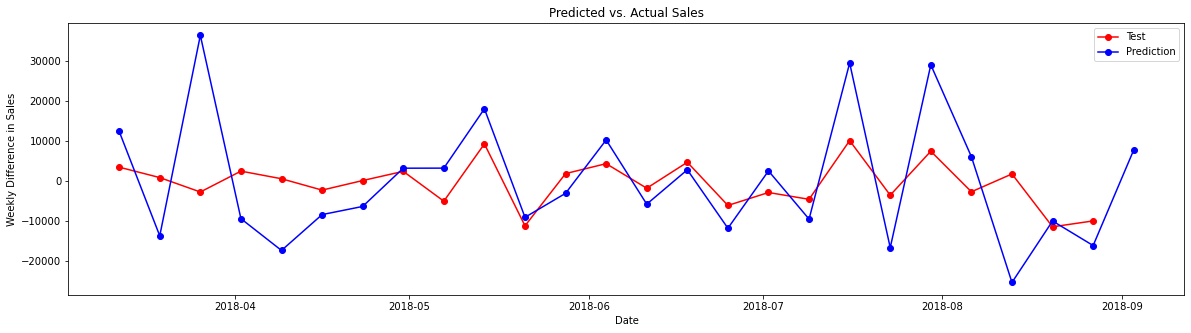

Lag: 20
Coefficients: const                5482.735578
L1.payment_value       -0.682709
L2.payment_value       -0.759642
L3.payment_value       -0.924217
L4.payment_value       -1.027233
L5.payment_value       -0.963710
L6.payment_value       -0.987407
L7.payment_value       -0.931199
L8.payment_value       -1.176529
L9.payment_value       -1.111103
L10.payment_value      -0.876462
L11.payment_value      -0.950945
L12.payment_value      -0.917797
L13.payment_value      -1.094434
L14.payment_value      -1.045608
L15.payment_value      -1.025347
L16.payment_value      -0.850828
L17.payment_value      -1.199594
L18.payment_value      -0.024881
L19.payment_value      -0.016664
L20.payment_value      -0.244718
dtype: float64


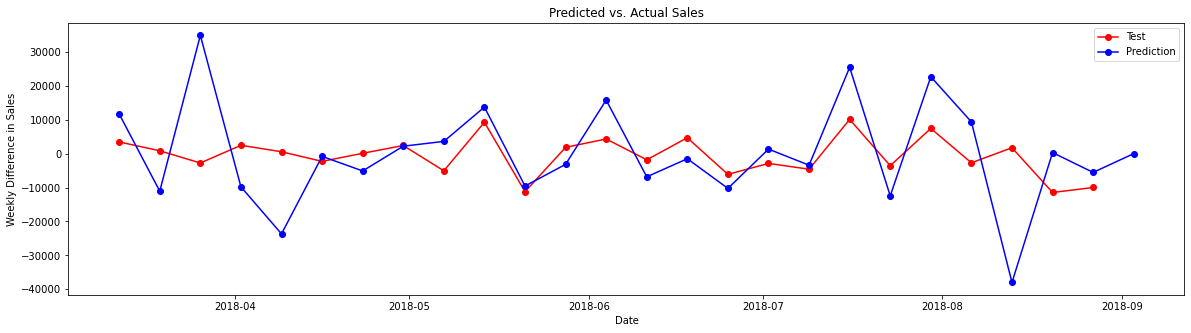

In [382]:
from statsmodels.tsa.ar_model import AR

MaxLagValues = [8, 13, 17, 20]

for i in MaxLagValues:
    model = AR(train)
    model_fit = model.fit(maxlag = i)
    
    print('Lag: %s' % model_fit.k_ar)
    print('Coefficients: %s' % model_fit.params)
    
    predictions = model_fit.predict(start=len(train), end=len(train+test))

    plt.figure(figsize = (20, 5))
    plt.plot(test, c="red", label="Test", marker='o')
    plt.plot(predictions, c="blue", label="Prediction", marker='o')
    plt.ylabel('Weekly Difference in Sales')
    plt.xlabel('Date')
    plt.title('Predicted vs. Actual Sales')
    plt.legend()
    plt.show();



From the above AR models, we see some very interesting results. Where for lag values of 8 and 13, our model demonstrates an ability to predict the 1st ~3 weeks of the sales data where afterwards it quickly converges to a straight line that does not define much, at a lag value of 17 and 20, we see our model attempting to predict the full range of the test dataset that spans nearly 7 months. In these cases, our model does not do very well at predicting the ~1 month of the data, but is able to predict the middle ~3 months of sales, following the test data fairly tightly, before diverging from the test data near the end.

These results are rather astounding given the expectations from a timeseries analysis. In most cases, it would be incredible to see a model which is able to predict more than a couple points in the future, as seen with the lag values of 8 and 13 in our case, but to have a model, which works to predict nearly a full year's worth of sales, as seen in lags of 17 and 20, it raises a few concerns as to whether it is indeed the model performing this way, or if it is otherwise a potential byproduct of something else in the data that we haven't considered.

Lag: 8
Coefficients: const               1180.555966
L1.payment_value      -0.497413
L2.payment_value      -0.516041
L3.payment_value      -0.516500
L4.payment_value      -0.477842
L5.payment_value      -0.434683
L6.payment_value      -0.344007
L7.payment_value      -0.278902
L8.payment_value      -0.332398
dtype: float64


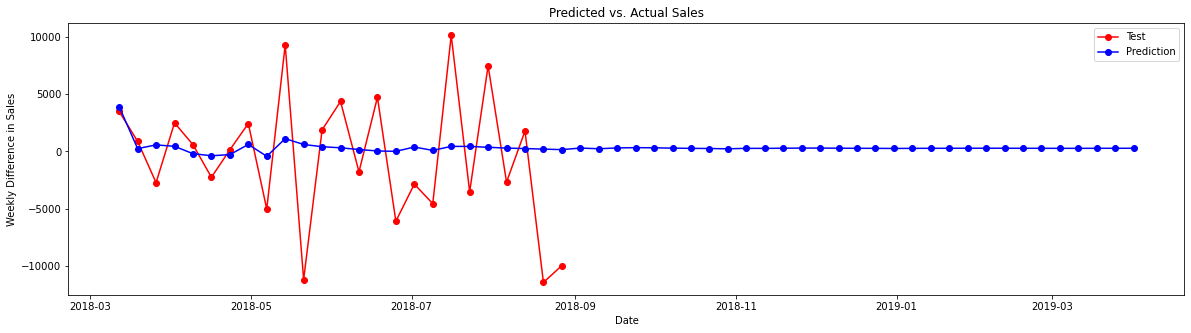

Lag: 13
Coefficients: const                1536.161785
L1.payment_value       -0.549426
L2.payment_value       -0.559022
L3.payment_value       -0.575302
L4.payment_value       -0.587785
L5.payment_value       -0.591347
L6.payment_value       -0.500791
L7.payment_value       -0.447605
L8.payment_value       -0.513357
L9.payment_value       -0.273233
L10.payment_value      -0.064872
L11.payment_value      -0.161938
L12.payment_value      -0.112323
L13.payment_value      -0.181572
dtype: float64


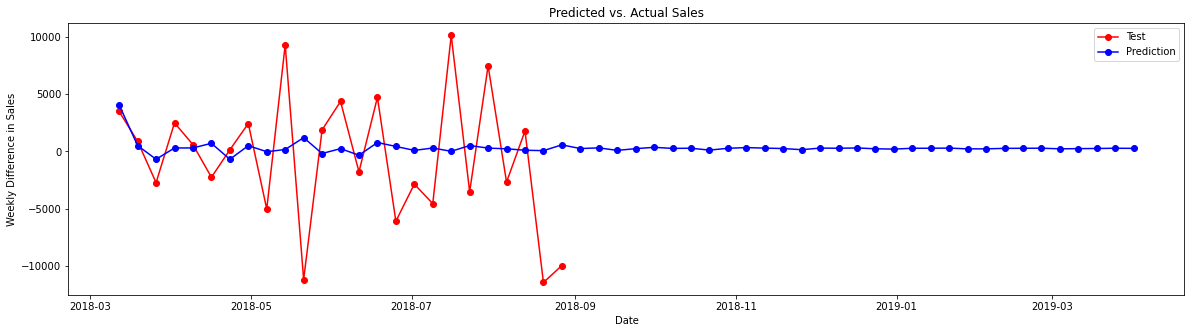

Lag: 17
Coefficients: const                5364.083583
L1.payment_value       -0.693873
L2.payment_value       -0.780611
L3.payment_value       -0.898117
L4.payment_value       -1.022080
L5.payment_value       -0.958275
L6.payment_value       -0.984217
L7.payment_value       -0.878467
L8.payment_value       -1.130013
L9.payment_value       -1.047056
L10.payment_value      -0.862012
L11.payment_value      -0.902819
L12.payment_value      -0.835745
L13.payment_value      -1.011149
L14.payment_value      -0.971571
L15.payment_value      -0.970372
L16.payment_value      -0.760838
L17.payment_value      -1.178124
dtype: float64


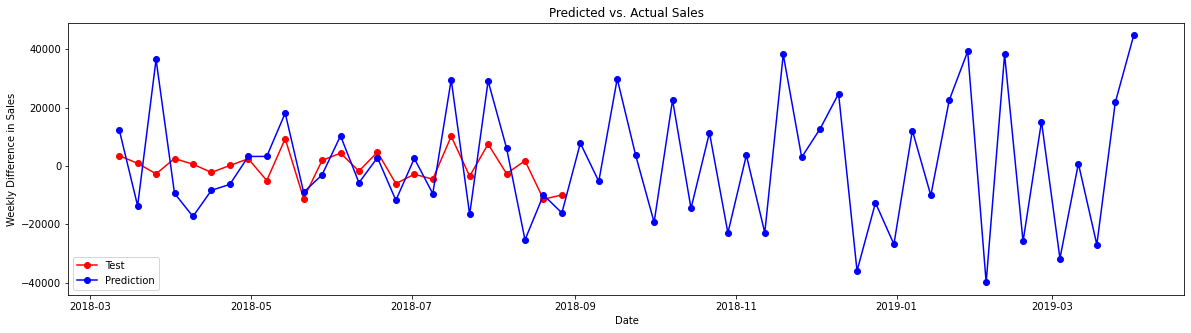

Lag: 20
Coefficients: const                5482.735578
L1.payment_value       -0.682709
L2.payment_value       -0.759642
L3.payment_value       -0.924217
L4.payment_value       -1.027233
L5.payment_value       -0.963710
L6.payment_value       -0.987407
L7.payment_value       -0.931199
L8.payment_value       -1.176529
L9.payment_value       -1.111103
L10.payment_value      -0.876462
L11.payment_value      -0.950945
L12.payment_value      -0.917797
L13.payment_value      -1.094434
L14.payment_value      -1.045608
L15.payment_value      -1.025347
L16.payment_value      -0.850828
L17.payment_value      -1.199594
L18.payment_value      -0.024881
L19.payment_value      -0.016664
L20.payment_value      -0.244718
dtype: float64


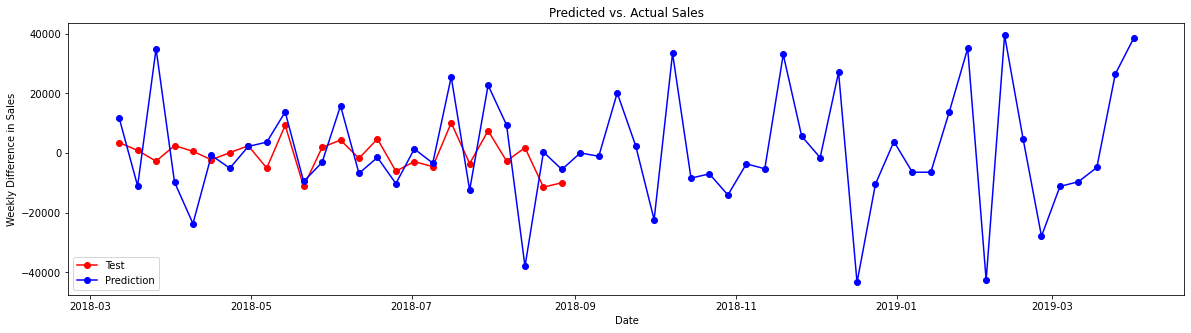

In [383]:
#Replotting the AR graphs - but now asking the model to predict beyond the test data
from statsmodels.tsa.ar_model import AR

MaxLagValues = [8, 13, 17, 20]

for i in MaxLagValues:
    model = AR(train)
    model_fit = model.fit(maxlag = i)
    
    print('Lag: %s' % model_fit.k_ar)
    print('Coefficients: %s' % model_fit.params)
    
    predictions = model_fit.predict(start=len(train), end=len(train+test)+30)

    plt.figure(figsize = (20, 5))
    plt.plot(test, c="red", label="Test", marker='o')
    plt.plot(predictions, c="blue", label="Prediction", marker='o')
    plt.ylabel('Weekly Difference in Sales')
    plt.xlabel('Date')
    plt.title('Predicted vs. Actual Sales')
    plt.legend()
    plt.show();



We attempted to re-plot the AR model, but now asking it to predict 30 weeks beyond the test data. For lag values of 8 and 13, we see the model converges to 0, giving us no predictions for sales. For lag values of 17 and 20 however, we see the model continuing to attempt weekly sales difference predictions, showing no pattern of convergence to zero. This is highly odd. We would expect the model to converge to zero as the model uses its previous predictions to make future predictions, which should ultimately lead to smaller and smaller differences that force the model towards zero. To further evaluate this, we revisited the stationary data that we generated through the 1st order differencing.

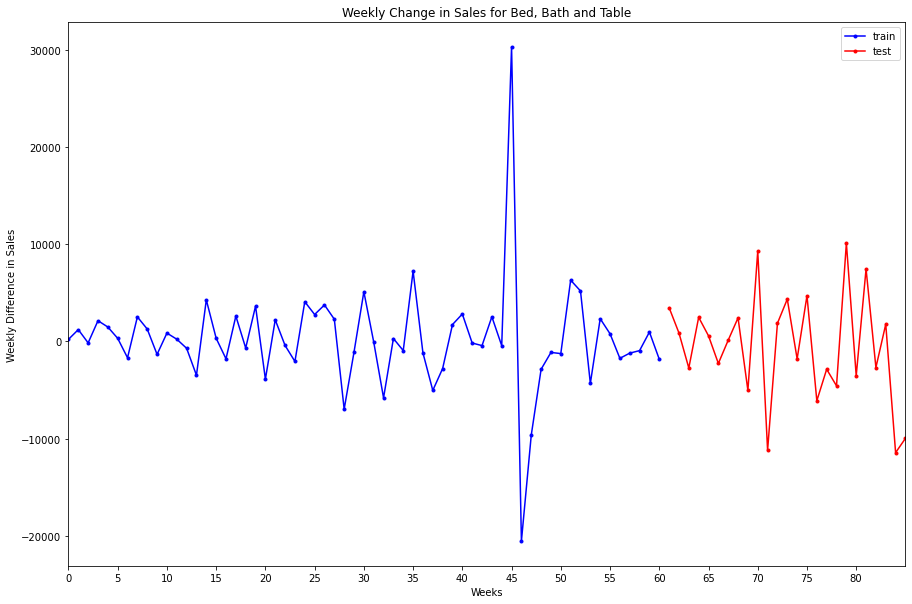

In [384]:
#Re-plotting the stationary data with train and test data separated by colour
plt.figure(figsize = (15,10))
ax = plt.gca()
plt.plot(list(range(0, len(train))), train, c="blue", label="train", marker = '.')
plt.plot(list(range(len(train), len(train)+len(test))),test, c="red", label="test", marker = '.')
plt.legend()
plt.xlabel('Weeks')
plt.ylabel('Weekly Difference in Sales')
plt.title('Weekly Change in Sales for Bed, Bath and Table')
plt.xlim([0, 85])
plt.xticks(range(0,85, 5))
plt.show();

Looking at the train data (blue) in the above plot, we can see that when using a lag value of 17 and 20, we in fact take into account the large spike in our data that occurs between weeks 44 and 46. This spike, when looking at the plot at the beginning of this notebook, occurs around Christmas time, as would be expected, since a lot of shopping occurs during this season. This may also be the reason why we see our AR model not converging to zero when using the lag values of 17 and 20. With such a huge shock in the data being taken into account when making future predictions, it may be influencing the model's behaviour. While, we can't be sure just how this is affecting the model, it can be the likely explanation for the difference in results seen between the lags 8/13 and lags 17/20. 

For our modelling purposes, we will attempt to build and optimize the ARIMA model using all 4 autoregressive values (8,13,17,20) and see how the model behaves, and if one is able to predict the data better than the others. 

### ARIMA Model

An ARIMA model is a combinations of the AR model, moving average (MA) model and integrative (I) model, as described by the name, Auto-Regressive, Integrated, Moving Average model. In this case, we can combine our findings from the AR model above, with an additional Moving average and Integrated term to build a more complete and coherent time series model. 

Where the Integrated term can be described as the order of difference, the moving average term acts more of a smoothing factor aiding in removing excessive noise from the data such that data trends are more visible.

In our case above, we have already applied an integrated term in a way, when we took the 1st order difference of our data to make it stationary. While, from the Dickey-Fuller test, we were able to make the assumption that the 1st order difference was enough to yield a stationary dataset, we can further experiment with this term in the ARIMA model to determine if higher order differencing can yield better results.

As for the moving average term. We have already preprocessed the data to yield weekly sums of the sales, as such, we have inherently applied a form of noise reduction in the data. While, we do not have data only a regular daily basis to build a model using daily sales, aggregated the sales over each week, has allowed us to evaluate our data through this time series analysis. In doing so, we have implicitly applied a smoothing factor, which may be the reason we did not see any significant autocorrelation terms from our autocorrelation plot. Given that we did not see any lag values that yielded autocorrelations outside of the 95% confidence intervals, we did see a convergence of autocorrelation to zero as we increased the number of lag terms, with autocorrelation being essentially zero after the lag of 20. Thus, while we do not have a statistical basis to evaluate our model using any MA term, we can determine if varying terms between 0 and 20 give us better results.

While we can evaluate our model visually to see how it performs against the true test data, we need to also implement a test which can help us objectively determine the best parameters (AR, I, MA) for the ARIMA model. For this, we will implement the root mean square error. Given that our model is essentially a regression problem, we can use the RMSE to find the parameters where the error is minimized which would suggest the best fitting model.

Given the large spike in the data around christmas time, our data also suggests that seasonality plays a role. Thus, we will also implement the SARIMAX model, which is a variant of the ARIMA model that evaluates for data where seasonality has an effect.

In [360]:
#Determing the parameters that yield the smallest RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings("ignore")

min_RMSE = float('inf')
AR_values = [8, 13, 17, 20]
D_values = [0]
Q_values = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
trend_values = ['t', 'n', 'ct', 'c']

#Evaluating the AR term
for p in AR_values:
    #Evaluating various Integrated terms
    for d in D_values: 
        #Evaluating various MA terms
        for q in Q_values:
            #Evaluating various trend terms
            for i in trend_values:
            
                model = SARIMAX(train, order=(p,d,q), enforce_stationarity=False, enforce_invertibility=False, trend=i)

                model_fit = model.fit()
                predictions = model_fit.predict(start = len(train), end = len(train+test)-1)

                RMSE = sqrt(mean_squared_error(test, predictions))

                #Printing out only the parameters for which RMSE is minimal
                if RMSE < min_RMSE:
                    min_RMSE = RMSE
                    print(f'{p}, {d}, {q}, {i} : RMSE - {RMSE}')

8, 0, 0, t : RMSE - 5608.977336502276
8, 0, 0, n : RMSE - 5559.102061928699
8, 0, 0, ct : RMSE - 5516.681235834368
8, 0, 13, t : RMSE - 5513.36935685773
8, 0, 13, c : RMSE - 5512.230790237726
8, 0, 15, t : RMSE - 5385.896662799755
8, 0, 15, ct : RMSE - 5385.872192979111
13, 0, 12, n : RMSE - 5209.43111561757


Ranging over various p,d,q parameters and all possible `trends`, we see that our model performs best with an `AR` term of 13, `integrated term` of 0, `MA` term of 12 and `trend` being nonlinear ('n'). Interesting, we did attempt to test our model against more integrated values, but their combination with larger MA terms resulted in an error where our model reached a null, or infinite value. Thus, to overcome this, and ensure our model is being tested against all possible choices, we will re-run the model, using different D_values and Q_Values to determine if there is another combination when using a different D_value that yields a smaller RMSE. 

In [258]:
#Re-testing our SARIMAX model using different combinations of integrated and MA terms
import warnings
warnings.filterwarnings("ignore")

min_RMSE = float('inf')
AR_values = [8, 13, 17, 20]
D_values = [0,1,2,3]
Q_values = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
trend_values = ['t', 'n', 'ct', 'c']

#Evaluating the AR term
for p in AR_values:
    #Evaluating various Integrated terms
    for d in D_values: 
        #Evaluating various MA terms
        for q in Q_values:
            #Evaluating various trend terms
            for i in trend_values:
            
                model = SARIMAX(train, order=(p,d,q), enforce_stationarity=False, enforce_invertibility=False, trend=i)

                model_fit = model.fit()
                predictions = model_fit.predict(start = len(train), end = len(train+test)-1)

                RMSE = sqrt(mean_squared_error(test, predictions))

                #Printing out only the parameters for which RMSE is minimal
                if RMSE < min_RMSE:
                    min_RMSE = RMSE
                    print(f'{p}, {d}, {q}, {i} : RMSE - {RMSE}')


8, 0, 0, t : RMSE - 5608.977336502276
8, 0, 0, n : RMSE - 5559.102061928699
8, 0, 0, ct : RMSE - 5516.681235834368
8, 0, 13, t : RMSE - 5513.36935685773
8, 0, 13, c : RMSE - 5512.230790237726
8, 1, 0, t : RMSE - 5478.427345438286
8, 1, 0, ct : RMSE - 5477.216371929911
8, 1, 13, c : RMSE - 5312.506525290072
13, 0, 12, n : RMSE - 5209.43111561757


Testing more integrated terms, we continue to see our model performing its best when our AR term is equal to 13. Moreover, when comparing the results of this test to our previous run, we still see the combination of p,d,q = 13,0,12 yielding the lowest RMSE with trend set to 'n'. While, we can continue to test more combinations of these parameters, the range of parameters tested above provides with good insight on where our model is performing its best. We can now visualize our results to see how the model performs against the true values using p,d,q = 13,0,12 respectively and trend set to 'n'.

MAPE: 121.13%


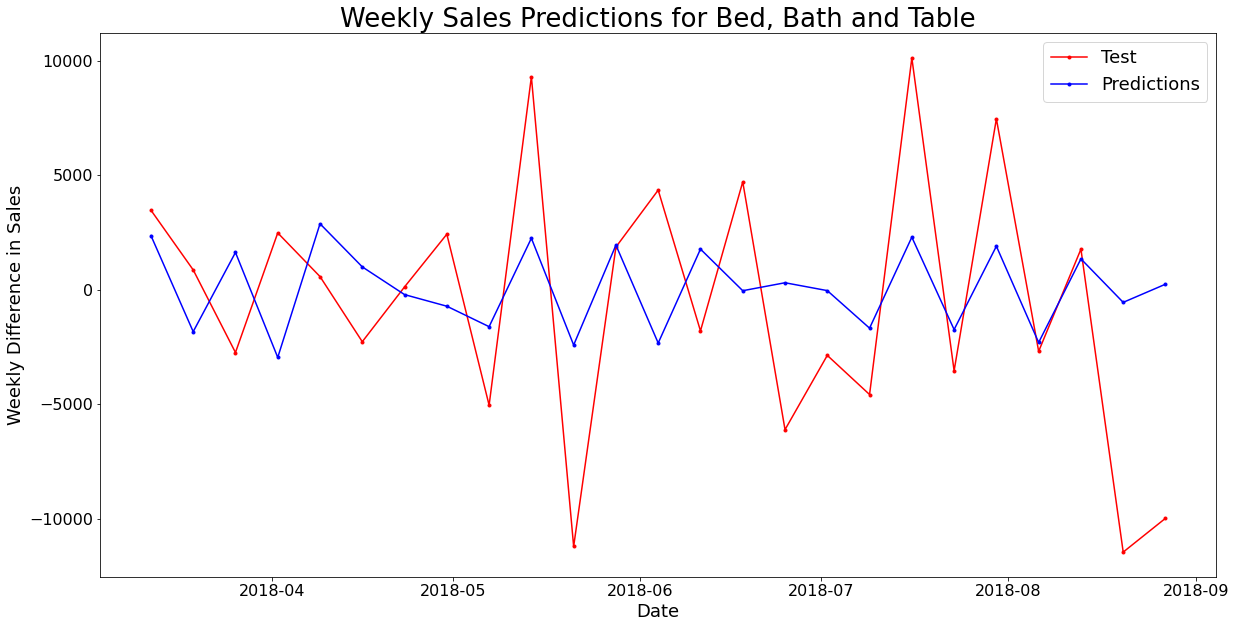

In [389]:
#Plotting the most optimzed model and checking it against the actual sales
model = SARIMAX(train, order=(13,0,12), enforce_invertibility=False, enforce_stationarity=False, trend='n')
model_fit = model.fit()
predictions = model_fit.predict(start=len(train), end=len(train+test)-1)

mape = np.mean(np.abs((np.array(test['payment_value']) - np.array(predictions)) / np.array(test['payment_value']))) * 100
print(f'MAPE: {mape:.2f}%')

plt.figure(figsize = (20,10))
plt.plot(test, c = 'r', label='Test', marker='.')
plt.plot(predictions, c = 'b', label='Predictions',  marker='.')
ax = plt.gca()
ax.set_xlabel("Date", size=18)
ax.set_ylabel('Weekly Difference in Sales', size=18)
ax.set_title('Weekly Sales Predictions for Bed, Bath and Table', size = 26)
ax.tick_params(axis="x", labelsize=16)
ax.tick_params(axis="y", labelsize=16)
plt.legend( prop={"size":18})
plt.savefig('arima model', transparent = True, dpi = 300, bbox_inches = 'tight')
plt.show()



From the results, we can see that the model isn't performing very well. While it does follow the generic trend of the actual sale values, its predictions are far from perfect. Interestingly, the model seems to be performing better (visually) in the later half of the test window (2018-07 to 2018-09). For any timeseries, we would expect the predictions to worsen over time, but in this case, the model is struggling to accurately predict the first couple weeks of sales and then, gets better over time.

Looking at the mean absolute percentage error, it is extremely high and suggests that in many cases, the model predicted and increase in sales when we had a decrease and vise versa, which is what would yield a larger than 100% percentage error value. While the model was optimized for the smaller RMSE, the MAPE is shown here because of its ease in interpretability.

While not shown, the model was also tested for p,d,q and trend terms that would yield the smallest MAPE value, and this resulted in a different set of parameters which yielded a far worst visual model where most of the predictions were near zero. One reason for why we decided to use RMSE as the metric for choosing the best model, was its ability to apply higher weights to larger error values, vs. MAPE which would apply the same weight to each error value. Simply put, because we are squaring the difference between the predicted value and actual sales values for RMSE, before taking the average, it means that when we have a larger difference between the prediction and actual value, we would amplify its effect when squaring that error term as opposed to a small difference, which when squared would not result in a very large number.

Thus, this would mean, we find a model, where the predicted values are as close as possible to the actual sales. For MAPE on the other hand, because we do not square the difference between the predicted and actual value, we are not amplifying its effect.

Thus, we implemented RMSE for best model selection, but displayed MAPE for ease of understanding.

In [269]:
#Looking at the summary table of our most optimized SARIMA model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:          payment_value   No. Observations:                   61
Model:             SARIMAX(13, 0, 12)   Log Likelihood               -1539.701
Date:                Tue, 20 Oct 2020   AIC                           3131.403
Time:                        18:51:50   BIC                           3180.054
Sample:                    01-09-2017   HQIC                          3149.788
                         - 03-05-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6465      0.375     -1.726      0.084      -1.381       0.088
ar.L2         -0.6282      0.254     -2.471      0.013      -1.126      -0.130
ar.L3         -0.8361      0.157     -5.317      0.0

### Conclusion

In conclusion, our ARIMA model has not been able to show promising results. One likely reason for this is the lack of available data. With less than 2 years of data, we did not have 2 cycles of data to model ARIMA on. Furthermore, we trained our model on a set of points where we had an extremely large spike in the dataset which likely resulted in our model not being able to fit as well. 

This model served as a good first step, but we were limited in many ways. To further delve into this data and ensure we are obtaining the maximum insights, we next worked to implement the Facebook Prophet prediction model, which is much more flexible and not bound by some of the limitation we faced here. Please refer to the Facebook Prophet Notebook for the full analysis.

### References

1. https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/

2. https://www.kaggle.com/sumi25/understand-arima-and-tune-p-d-q

3. http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/